# **1. Setup**

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random
import os
import sys

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Activation, Average, AveragePooling2D
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.initializers import Initializer as KerasInitializer
from keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from keras.models import Model, Input
from keras.losses import categorical_crossentropy
#from keras.models import load_model

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/")

Mounted at /content/drive


In [5]:
# show variables memory usage

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        Conv2D:  1.0 KiB
                       Flatten:  1.0 KiB
                         Dense:  1.0 KiB
                       Dropout:  1.0 KiB
                  MaxPooling2D:  1.0 KiB
                    Activation:  1.0 KiB
                       Average:  1.0 KiB
              AveragePooling2D:  1.0 KiB
                    Sequential:  1.0 KiB
              KerasInitializer:  1.0 KiB


In [6]:
# data parameters

img_size = 150
input_shape = (img_size, img_size, 3)
num_classes = 43

In [7]:
# training parameters (just for testing the function, epoch=1)

learning_rate = 0.02
training_epochs = 20
batch_size = 128
dropout = 0.5
patience = 10
verbose = 1

In [8]:
# validation dataset proportion of training dataset

validation_split = 0.1

In [9]:
# early stopping
# this EarlyStopping will stop the training when there is no improvement 
# in the validation loss of 1% for 'patience' consecutive epochs

es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, verbose = verbose)

In [10]:
# initialization

k_initializer = tf.initializers.GlorotUniform() # Xavier Uniform
# b_initializer = initializers.Zeros()

In [11]:
# this input layer will be put into the proposed ensamble CNN as a commom block

model_input = keras.Input(shape = input_shape)

In [12]:
# optimizer

optimizer = keras.optimizers.SGD(learning_rate = learning_rate)

In [13]:
# create the architecture of 'model'

model = keras.Sequential(
    [
          model_input,
          layers.Conv2D(8, kernel_size = (3, 3), kernel_initializer = k_initializer, activation = "relu"),
          layers.AveragePooling2D(pool_size = (2, 2)),
          layers.Conv2D(16, kernel_size = (3, 3), kernel_initializer = k_initializer, activation = "relu"),
          layers.AveragePooling2D(pool_size = (2, 2)),
          layers.Conv2D(32, kernel_size = (3, 3), kernel_initializer = k_initializer, activation = "relu"),
          layers.AveragePooling2D(pool_size = (2, 2)),
          layers.Flatten(),
          layers.Dropout(dropout),
          #layers.Dense(5000, kernel_initializer = k_initializer, activation = "relu"),
          layers.Dense(1500, kernel_initializer = k_initializer, activation = "relu"),
          layers.Dense(800, kernel_initializer = k_initializer, activation = "relu"),
          layers.Dense(300, kernel_initializer = k_initializer, activation = "relu"),
          layers.Dense(num_classes, kernel_initializer = k_initializer, activation = "softmax")        
    ])

model_output = model(model_input)

# summarize the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 average_pooling2d (AverageP  (None, 74, 74, 8)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        1168      
                                                                 
 average_pooling2d_1 (Averag  (None, 36, 36, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        4640      
                                                                 
 average_pooling2d_2 (Averag  (None, 17, 17, 32)       0

In [14]:
# build the function for both compiling and training the model with validation

def compile_and_train(block, num_epochs): 
    
    block.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    history = block.fit(x_train, y_train, batch_size = batch_size, epochs = num_epochs, validation_split = validation_split, callbacks = [es])
    
    return history

In [15]:
# Preparing data

# load dataset
data = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/data.npy') 
labels = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/labels.npy') 

# split to test and train
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42)

# delete large variables
del data
del labels

# **2. Start training**

# **2.1) 0-9999 of train set**

In [16]:
# training a model with sliced train_set

slice_range = [0, 10000]

# slice train set
train_min, train_max = slice_range
x_train = x_train[train_min : train_max]
y_train = y_train[train_min : train_max]

# normalize image pixcel values from [0, 255] to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# # convert class vectors into one-hot encoded format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# make sure images have the shape, (150, 150, 3)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# compile & train
history_1 = compile_and_train(model, num_epochs = training_epochs)

# evaluate the trained model
score = model.evaluate(x_test, y_test, verbose = 0)
print("test loss of model:", score[0])
print("test accuracy of model:", score[1])

x_train shape: (10000, 150, 150, 3)
y_train shape: (10000, 43)
x_test shape: (3921, 150, 150, 3)
y_test shape: (3921, 43)
10000 train samples
3921 test samples
Epoch 1/20
71/71 [==============================] - 116s 2s/step - loss: 3.6473 - accuracy: 0.0579 - val_loss: 3.4914 - val_accuracy: 0.0590
Epoch 2/20
71/71 [==============================] - 117s 2s/step - loss: 3.4619 - accuracy: 0.0787 - val_loss: 3.4765 - val_accuracy: 0.0790
Epoch 3/20
71/71 [==============================] - 117s 2s/step - loss: 3.3411 - accuracy: 0.1304 - val_loss: 3.2814 - val_accuracy: 0.1670
Epoch 4/20
71/71 [==============================] - 117s 2s/step - loss: 3.0828 - accuracy: 0.2294 - val_loss: 2.7513 - val_accuracy: 0.3480
Epoch 5/20
71/71 [==============================] - 117s 2s/step - loss: 2.5504 - accuracy: 0.3561 - val_loss: 2.2862 - val_accuracy: 0.3880
Epoch 6/20
71/71 [==============================] - 117s 2s/step - loss: 2.0025 - accuracy: 0.4483 - val_loss: 1.9580 - val_accuracy: 0

In [23]:
# check point 1

model.save('/content/model1')

INFO:tensorflow:Assets written to: /content/models/assets


In [17]:
# create a function for combining scores

def combine_score(acc, val_acc, loss, val_loss, history):

  for a, va, l, vl in zip(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']) :
    acc.append(a)
    val_acc.append(va)
    loss.append(l)
    val_loss.append(vl)

In [18]:
# prepare to combine scores

acc = []
val_acc = []
loss = []
val_loss = []

In [19]:
combine_score(acc, val_acc, loss, val_loss, history_1)

In [20]:
# delete large variables
del x_train
del y_train
del x_test
del y_test

# **2.2) 10000-19999 of train set**

In [24]:
# Preparing data

# load dataset
data = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/data.npy') 
labels = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/labels.npy') 

# split to test and train
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42)

# delete large variables
del data
del labels

In [25]:
# continue training - 2nd time
# training a model with sliced train_set

slice_range = [10000, 20000]

# slice train set
train_min, train_max = slice_range
x_train = x_train[train_min : train_max]
y_train = y_train[train_min : train_max]

# normalize image pixcel values from [0, 255] to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# # convert class vectors into one-hot encoded format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# make sure images have the shape, (150, 150, 3)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# compile & train
history_2 = compile_and_train(model, num_epochs = training_epochs)

# evaluate the trained model
score = model.evaluate(x_test, y_test, verbose = 0)
print("test loss of model:", score[0])
print("test accuracy of model:", score[1])

x_train shape: (10000, 150, 150, 3)
y_train shape: (10000, 43)
x_test shape: (3921, 150, 150, 3)
y_test shape: (3921, 43)
10000 train samples
3921 test samples
Epoch 1/20
71/71 [==============================] - 120s 2s/step - loss: 0.3630 - accuracy: 0.9003 - val_loss: 0.3036 - val_accuracy: 0.9190
Epoch 2/20
71/71 [==============================] - 120s 2s/step - loss: 0.2738 - accuracy: 0.9220 - val_loss: 0.2084 - val_accuracy: 0.9480
Epoch 3/20
71/71 [==============================] - 120s 2s/step - loss: 0.2310 - accuracy: 0.9363 - val_loss: 0.2017 - val_accuracy: 0.9560
Epoch 4/20
71/71 [==============================] - 120s 2s/step - loss: 0.2006 - accuracy: 0.9424 - val_loss: 0.2292 - val_accuracy: 0.9420
Epoch 5/20
71/71 [==============================] - 120s 2s/step - loss: 0.1880 - accuracy: 0.9467 - val_loss: 0.2708 - val_accuracy: 0.9300
Epoch 6/20
71/71 [==============================] - 120s 2s/step - loss: 0.1628 - accuracy: 0.9514 - val_loss: 0.2329 - val_accuracy: 0

In [26]:
# check point 2

model.save('/content/model2')

INFO:tensorflow:Assets written to: /content/model2/assets


In [27]:
combine_score(acc, val_acc, loss, val_loss, history_2)

In [28]:
# delete large variables
del x_train
del y_train
del x_test
del y_test

# **2.3) 20000-29999 of train set**

In [29]:
# Preparing data

# load dataset
data = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/data.npy') 
labels = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/labels.npy') 

# split to test and train
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42)

# delete large variables
del data
del labels

In [30]:
# continue training - 2nd time
# training a model with sliced train_set

slice_range = [20000, 30000]

# slice train set
train_min, train_max = slice_range
x_train = x_train[train_min : train_max]
y_train = y_train[train_min : train_max]

# normalize image pixcel values from [0, 255] to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# # convert class vectors into one-hot encoded format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# make sure images have the shape, (150, 150, 3)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# compile & train
history_3 = compile_and_train(model, num_epochs = training_epochs)

# evaluate the trained model
score = model.evaluate(x_test, y_test, verbose = 0)
print("test loss of model:", score[0])
print("test accuracy of model:", score[1])

x_train shape: (10000, 150, 150, 3)
y_train shape: (10000, 43)
x_test shape: (3921, 150, 150, 3)
y_test shape: (3921, 43)
10000 train samples
3921 test samples
Epoch 1/20
71/71 [==============================] - 122s 2s/step - loss: 0.2303 - accuracy: 0.9418 - val_loss: 0.2494 - val_accuracy: 0.9470
Epoch 2/20
71/71 [==============================] - 121s 2s/step - loss: 0.1679 - accuracy: 0.9520 - val_loss: 0.2050 - val_accuracy: 0.9480
Epoch 3/20
71/71 [==============================] - 122s 2s/step - loss: 0.1335 - accuracy: 0.9656 - val_loss: 0.1164 - val_accuracy: 0.9730
Epoch 4/20
71/71 [==============================] - 121s 2s/step - loss: 0.1033 - accuracy: 0.9697 - val_loss: 0.1101 - val_accuracy: 0.9770
Epoch 5/20
71/71 [==============================] - 121s 2s/step - loss: 0.0936 - accuracy: 0.9716 - val_loss: 0.1209 - val_accuracy: 0.9670
Epoch 6/20
71/71 [==============================] - 121s 2s/step - loss: 0.0940 - accuracy: 0.9758 - val_loss: 0.0977 - val_accuracy: 0

In [31]:
# check point 3

model.save('/content/model3')

INFO:tensorflow:Assets written to: /content/model3/assets


In [32]:
combine_score(acc, val_acc, loss, val_loss, history_3)

In [33]:
# delete large variables
del x_train
del y_train
del x_test
del y_test

# **2.4) 30000-Last of train set**

In [34]:
# Preparing data

# load dataset
data = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/data.npy') 
labels = np.load('/content/drive/MyDrive/Vision for Mobile Robitics Class/final_project/dataset_as_np/labels.npy') 

# split to test and train
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.1, random_state = 42)

# delete large variables
del data
del labels

In [35]:
# continue training - 2nd time
# training a model with sliced train_set

slice_range = [30000, -1]

# slice train set
train_min, train_max = slice_range
x_train = x_train[train_min : ]
y_train = y_train[train_min : ]

# normalize image pixcel values from [0, 255] to [0, 1]
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

# # convert class vectors into one-hot encoded format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# make sure images have the shape, (150, 150, 3)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# compile & train
history_4 = compile_and_train(model, num_epochs = training_epochs)

# evaluate the trained model
score = model.evaluate(x_test, y_test, verbose = 0)
print("test loss of model:", score[0])
print("test accuracy of model:", score[1])

x_train shape: (5288, 150, 150, 3)
y_train shape: (5288, 43)
x_test shape: (3921, 150, 150, 3)
y_test shape: (3921, 43)
5288 train samples
3921 test samples
Epoch 1/20
38/38 [==============================] - 65s 2s/step - loss: 0.1900 - accuracy: 0.9534 - val_loss: 0.0925 - val_accuracy: 0.9735
Epoch 2/20
38/38 [==============================] - 64s 2s/step - loss: 0.1362 - accuracy: 0.9605 - val_loss: 0.1564 - val_accuracy: 0.9527
Epoch 3/20
38/38 [==============================] - 64s 2s/step - loss: 0.1003 - accuracy: 0.9708 - val_loss: 0.7606 - val_accuracy: 0.8639
Epoch 4/20
38/38 [==============================] - 64s 2s/step - loss: 0.1279 - accuracy: 0.9620 - val_loss: 0.5194 - val_accuracy: 0.8828
Epoch 5/20
38/38 [==============================] - 65s 2s/step - loss: 0.1274 - accuracy: 0.9676 - val_loss: 0.0698 - val_accuracy: 0.9735
Epoch 6/20
38/38 [==============================] - 65s 2s/step - loss: 0.0678 - accuracy: 0.9794 - val_loss: 0.0716 - val_accuracy: 0.9754
Epo

In [37]:
combine_score(acc, val_acc, loss, val_loss, history_4)

In [38]:
# delete large variables
del x_train
del y_train
#del x_test
#del y_test

In [39]:
# check point 4

model.save('/content/model4')

INFO:tensorflow:Assets written to: /content/model4/assets


**Download model.zip**

In [40]:
# zip /content/model to /content/model.zip

!zip -r /content/model1.zip /content/model1
!zip -r /content/model2.zip /content/model2
#!zip -r /content/model3.zip /content/model3
!zip -r /content/model4.zip /content/model4

  adding: content/model1/ (stored 0%)
  adding: content/model1/assets/ (stored 0%)
  adding: content/model1/variables/ (stored 0%)
  adding: content/model1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model1/variables/variables.index (deflated 58%)
  adding: content/model1/saved_model.pb (deflated 89%)
  adding: content/model1/keras_metadata.pb (deflated 93%)
  adding: content/model2/ (stored 0%)
  adding: content/model2/assets/ (stored 0%)
  adding: content/model2/variables/ (stored 0%)
  adding: content/model2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/model2/variables/variables.index (deflated 58%)
  adding: content/model2/saved_model.pb (deflated 89%)
  adding: content/model2/keras_metadata.pb (deflated 93%)
  adding: content/model4/ (stored 0%)
  adding: content/model4/assets/ (stored 0%)
  adding: content/model4/variables/ (stored 0%)
  adding: content/model4/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: co

In [43]:
# download the zip file

from google.colab import files

files.download("/content/model1.zip")
files.download("/content/model2.zip")
#files.download("/content/model3.zip")
files.download("/content/model4.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **3. Evaluation graph**

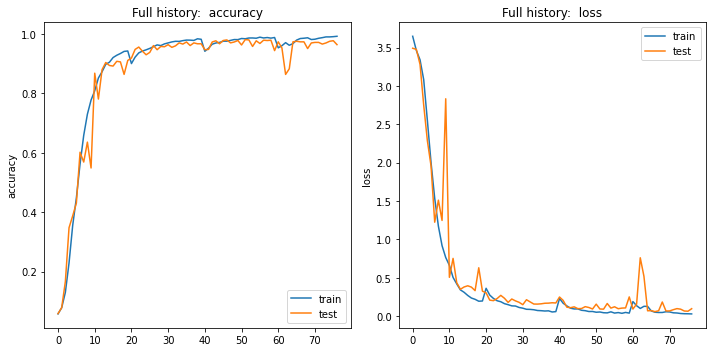

In [41]:
# graph of all history

title = 'Full history: '

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(acc)
axs[0].plot(val_acc)
axs[0].set_title(title + ' accuracy')
axs[0].set_ylabel('accuracy')
axs[0].legend(['train', 'test'], loc ='lower right')

# summarize the history of loss

axs[1].plot(loss)
axs[1].plot(val_loss)
axs[1].set_title(title + ' loss')
axs[1].set_ylabel('loss')
axs[1].legend(['train', 'test'], loc ='upper right')

fig.tight_layout()

In [42]:
# show variables memory usage

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        x_test: 1009.6 MiB
                 EarlyStopping:  1.4 KiB
                          _i13:  1.2 KiB
                          _i25:  1.1 KiB
                          _i30:  1.1 KiB
                          _i35:  1.1 KiB
                          _i16:  1.1 KiB
                  MaxPooling2D:  1.0 KiB
                    Activation:  1.0 KiB
                       Average:  1.0 KiB


# **4. Ensemble model**

In [44]:
# build the function for (weighted) average ensemble

def ensemble_avg(models, model_input, weights = False):

  model_outputs = [model(model_input) for model in models]

  if weights != False:
    for i in range(len(model_outputs)):
      model_outputs[i] = model_outputs[i] * weights[i]

  avg = tf.keras.layers.Average()(model_outputs)
  ensemble = tf.keras.Model(inputs = model_input, outputs = avg)

  return ensemble

In [46]:
# load model 2,4

model2 = keras.models.load_model('/content/model2')
model4 = keras.models.load_model('/content/model4')

In [51]:
# rename to prevent error from ensemble_avg()

model2._name = 'model_2'
model4._name = 'model_4'

print(model2.name)
print(model4.name)

model_2
model_4


In [52]:
# generate data points for graph

models = [model2, model4]

test_loss_24 = []
test_acc_24 = []
for p in range(21):
  ensemble_model = ensemble_avg(models = models, model_input = model_input, weights = [0.1*p, 2.0 - 0.1*p])
  ensemble_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
  score = ensemble_model.evaluate(x_test, y_test, verbose = 0)
  test_loss_24.append(score[0])
  test_acc_24.append(score[1])

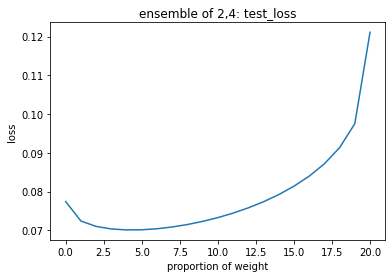

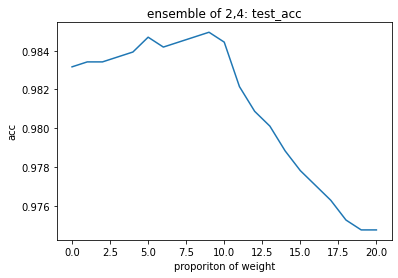

In [55]:
# display test_loss of ensemble of various model2,4 proportion
plt.plot(test_loss_24)
plt.title('ensemble of 2,4: test_loss')
plt.ylabel('loss')
plt.xlabel('proportion of weight')
plt.show()

# display test_acc of ensemble of various model2,4 proportion
plt.plot(test_acc_24)
plt.title('ensemble of 2,4: test_acc')
plt.ylabel('acc')
plt.xlabel('proporiton of weight')
plt.show()

In [53]:
# build the function for counting probability of weighted test_acc > single block test_acc
# , and print best weight proportion

def ensemble_evaluate(test_acc, title = 'no title'):

  # calculate probability
  count = 0
  for acc in test_acc:
    if acc > test_acc[0] and acc > test_acc[-1]:
      count = count + 1
  percent_better_acc = count / len(test_acc) * 100
  
  # find best weight proportion
  p = np.argmax(test_acc)
  p_A = 0.1 * p
  p_B = 2.0 - 0.1 * p

  # test_acc of each sub-model
  test_acc_A = test_acc[-1]
  test_acc_B = test_acc[0]

  # calculate improvement
  max_sub_model_acc = max(test_acc_A, test_acc_B)
  best_test_acc = np.max(test_acc)
  improvement = (best_test_acc - max_sub_model_acc) / max_sub_model_acc

  print(title)
  print(" better than single sub-model :", round(percent_better_acc, 3), "%")
  print(" best weight proportion :", round(p_A, 2), "of block_A,", round(p_B, 2), "of block_B")
  print(" highest test_acc :", round(best_test_acc, 3))
  print(" block_A test_acc :", round(test_acc_A, 3), "\n block_B test_acc :", round(test_acc_B, 3))
  print(" improvement :", round(improvement * 100, 3), "%")
  print()

In [54]:
ensemble_evaluate(test_acc_24, title = 'ensemble of model 2,4 : test_acc')

ensemble of model 2,4 : test_acc
 better than single sub-model : 47.619 %
 best weight proportion : 0.9 of block_A, 1.1 of block_B
 highest test_acc : 0.985
 block_A test_acc : 0.975 
 block_B test_acc : 0.983
 improvement : 0.182 %



**Create and download ensemble.zip**

In [56]:
# create best ensemble model
models = [model2, model4]
weights = [0.9, 1.1]

ensemble_model = ensemble_avg(models = models, model_input = model_input, weights = weights)
ensemble_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

# evaluate best ensemble model
score = ensemble_model.evaluate(x_test, y_test, verbose = 0)
print("test loss of best ensemble model:", score[0])
print("test accuracy of best ensemble model:", score[1])

test loss of ensemble model: 0.07231296598911285
test accuracy of ensemble model: 0.9849528074264526


In [59]:
ensemble_model.save('/content/ensemble')

INFO:tensorflow:Assets written to: /content/ensemble/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [60]:
!zip -r /content/ensemble.zip /content/ensemble

  adding: content/ensemble/ (stored 0%)
  adding: content/ensemble/assets/ (stored 0%)
  adding: content/ensemble/variables/ (stored 0%)
  adding: content/ensemble/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/ensemble/variables/variables.index (deflated 65%)
  adding: content/ensemble/saved_model.pb (deflated 90%)
  adding: content/ensemble/keras_metadata.pb (deflated 96%)


In [61]:
from google.colab import files

files.download("/content/ensemble.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>